# Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_selection import SequentialFeatureSelector
import plotly.express as px

np.random.seed(1234)

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
# mpl.rcParams.update({"axes.grid": True})

# 9.1 Polynomial Features

## Initial data load

In [3]:
def get_vehicle_data():
    vehicle_data = pd.read_csv("./data/auto-mpg.csv")
    vehicle_data["horsepower"] = pd.to_numeric(
        vehicle_data["horsepower"], errors="coerce"
    )
    vehicle_data.rename(columns={"horsepower": "hp"}, inplace=True)
    vehicle_data.dropna(inplace=True)
    return vehicle_data

In [4]:
vehicle_data = get_vehicle_data()
vehicle_data.head()

,mpg,cylinders,displacement,hp,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


## Use Just a Few Features and Low Order

In [5]:
vehicle_data = get_vehicle_data()
poly_transform = PolynomialFeatures(degree=3, include_bias=False)
features = ["hp", "weight", "displacement"]
features = ["hp", "weight"]
vehicle_data_with_squared_features = pd.DataFrame(
    poly_transform.fit_transform(vehicle_data[features]),
    columns=poly_transform.get_feature_names_out(),
)

vehicle_data_with_squared_features

,hp,weight,hp^2,hp weight,weight^2,hp^3,hp^2 weight,hp weight^2,weight^3
0,130.0,3504.0,16900.0,455520.0,12278016.0,2197000.0,59217600.0,1.596142e+09,4.302217e+10
1,165.0,3693.0,27225.0,609345.0,13638249.0,4492125.0,100541925.0,2.250311e+09,5.036605e+10
2,150.0,3436.0,22500.0,515400.0,11806096.0,3375000.0,77310000.0,1.770914e+09,4.056575e+10
3,150.0,3433.0,22500.0,514950.0,11785489.0,3375000.0,77242500.0,1.767823e+09,4.045958e+10
4,140.0,3449.0,19600.0,482860.0,11895601.0,2744000.0,67600400.0,1.665384e+09,4.102793e+10
...,...,...,...,...,...,...,...,...,...
387,86.0,2790.0,7396.0,239940.0,7784100.0,636056.0,20634840.0,6.694326e+08,2.171764e+10
388,52.0,2130.0,2704.0,110760.0,4536900.0,140608.0,5759520.0,2.359188e+08,9.663597e+09
389,84.0,2295.0,7056.0,192780.0,5267025.0,592704.0,16193520.0,4.424301e+08,1.208782e+10
390,79.0,2625.0,6241.0,207375.0,6890625.0,493039.0,16382625.0,5.443594e+08,1.808789e+10


## Parameter Search

Using just a limited poly degree, the number of composite features rapidly expands
- For example with degree 2 only and 3 features, you get 9 composite features
- To search this space alone over effective features would require 2^9 model fits
- How to manage this rapidly expanding search space?

## Add Features and Increase Degree

Space jumps to 55 features, which would take "millions" of years to search for effectivity
- Need a better approach!

In [6]:
poly_transform = PolynomialFeatures(degree=3, include_bias=False)
features = ["cylinders", "displacement", "hp", "weight", "acceleration"]
degree_3_combos = pd.DataFrame(
    poly_transform.fit_transform(vehicle_data[features]),
    columns=poly_transform.get_feature_names_out(),
)

degree_3_combos

,cylinders,displacement,hp,weight,acceleration,cylinders^2,cylinders displacement,cylinders hp,cylinders weight,cylinders acceleration,displacement^2,displacement hp,displacement weight,displacement acceleration,hp^2,hp weight,hp acceleration,weight^2,weight acceleration,acceleration^2,cylinders^3,cylinders^2 displacement,cylinders^2 hp,cylinders^2 weight,cylinders^2 acceleration,cylinders displacement^2,cylinders displacement hp,cylinders displacement weight,cylinders displacement acceleration,cylinders hp^2,cylinders hp weight,cylinders hp acceleration,cylinders weight^2,cylinders weight acceleration,cylinders acceleration^2,displacement^3,displacement^2 hp,displacement^2 weight,displacement^2 acceleration,displacement hp^2,displacement hp weight,displacement hp acceleration,displacement weight^2,displacement weight acceleration,displacement acceleration^2,hp^3,hp^2 weight,hp^2 acceleration,hp weight^2,hp weight acceleration,hp acceleration^2,weight^3,weight^2 acceleration,weight acceleration^2,acceleration^3
0,8.0,307.0,130.0,3504.0,12.0,64.0,2456.0,1040.0,28032.0,96.0,94249.0,39910.0,1075728.0,3684.0,16900.0,455520.0,1560.0,12278016.0,42048.0,144.00,512.0,19648.0,8320.0,224256.0,768.0,753992.0,319280.0,8605824.0,29472.0,135200.0,3644160.0,12480.0,98224128.0,336384.0,1152.00,28934443.0,12252370.0,330248496.0,1130988.0,5188300.0,139844640.0,478920.0,3.769351e+09,12908736.0,44208.00,2197000.0,59217600.0,202800.0,1.596142e+09,5466240.0,18720.00,4.302217e+10,147336192.0,504576.00,1728.000
1,8.0,350.0,165.0,3693.0,11.5,64.0,2800.0,1320.0,29544.0,92.0,122500.0,57750.0,1292550.0,4025.0,27225.0,609345.0,1897.5,13638249.0,42469.5,132.25,512.0,22400.0,10560.0,236352.0,736.0,980000.0,462000.0,10340400.0,32200.0,217800.0,4874760.0,15180.0,109105992.0,339756.0,1058.00,42875000.0,20212500.0,452392500.0,1408750.0,9528750.0,213270750.0,664125.0,4.773387e+09,14864325.0,46287.50,4492125.0,100541925.0,313087.5,2.250311e+09,7007467.5,21821.25,5.036605e+10,156839863.5,488399.25,1520.875
2,8.0,318.0,150.0,3436.0,11.0,64.0,2544.0,1200.0,27488.0,88.0,101124.0,47700.0,1092648.0,3498.0,22500.0,515400.0,1650.0,11806096.0,37796.0,121.00,512.0,20352.0,9600.0,219904.0,704.0,808992.0,381600.0,8741184.0,27984.0,180000.0,4123200.0,13200.0,94448768.0,302368.0,968.00,32157432.0,15168600.0,347462064.0,1112364.0,7155000.0,163897200.0,524700.0,3.754339e+09,12019128.0,38478.00,3375000.0,77310000.0,247500.0,1.770914e+09,5669400.0,18150.00,4.056575e+10,129867056.0,415756.00,1331.000
3,8.0,304.0,150.0,3433.0,12.0,64.0,2432.0,1200.0,27464.0,96.0,92416.0,45600.0,1043632.0,3648.0,22500.0,514950.0,1800.0,11785489.0,41196.0,144.00,512.0,19456.0,9600.0,219712.0,768.0,739328.0,364800.0,8349056.0,29184.0,180000.0,4119600.0,14400.0,94283912.0,329568.0,1152.00,28094464.0,13862400.0,317264128.0,1108992.0,6840000.0,156544800.0,547200.0,3.582789e+09,12523584.0,43776.00,3375000.0,77242500.0,270000.0,1.767823e+09,6179400.0,21600.00,4.045958e+10,141425868.0,494352.00,1728.000
4,8.0,302.0,140.0,3449.0,10.5,64.0,2416.0,1120.0,27592.0,84.0,91204.0,42280.0,1041598.0,3171.0,19600.0,482860.0,1470.0,11895601.0,36214.5,110.25,512.0,19328.0,8960.0,220736.0,672.0,729632.0,338240.0,8332784.0,25368.0,156800.0,3862880.0,11760.0,95164808.0,289716.0,882.00,27543608.0,12768560.0,314562596.0,957642.0,5919200.0,145823720.0,443940.0,3.592472e+09,10936779.0,33295.50,2744000.0,67600400.0,205800.0,1.665384e+09,5070030.0,15435.00,4.102793e+10,124903810.5,380252.25,1157.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,4.0,140.0,86.0,2790.0,15.6,16.0,560.0,344.0,11160.0,62.4,19600.0,12040.0,390600.0,2184.0,7396.0,239940.0,1341.6,7784100.0,43524.0,243.36,64.0,2240.0,1376.0,44640.0,249.6,78400.0,48160.0,1562400.0,8736.0,29584.0,959760.0,5366.4,31136400.0,174096.0,973.44,2744000.0,1685600.0,54684000.0,305760.0,1035440.0,33591600

## Better Approach to Explore

Alternate approaches considered henceforth
- Sequential feature selection (SFS)
- Regularization

# 9.2 Sequential Feature Selection

## Review Previously Obtained Performance

Pipeline with poly xformer and linear regression

In [7]:
def make_model(
    degree: int = 0,
    df: pd.DataFrame = vehicle_data,
    features: list[str] = ["hp"],
):
    model = Pipeline(
        [
            ("transform", PolynomialFeatures(degree=degree, include_bias=False)),
            ("regression", LinearRegression(fit_intercept=True)),
        ]
    )

    model.fit(df[features], df["mpg"])
    return model

In [8]:
def get_mse_for_degree(
    degree: int = 0,
    df_train: pd.DataFrame = vehicle_data,
    df_dev: pd.DataFrame = vehicle_data,
    features: list[str] = ["hp"],
):
    model = make_model(degree=degree, df=df_train, features=features)
    num_composite_features = len(model[0].get_feature_names_out())
    mse_train = mean_squared_error(df_train["mpg"], model.predict(df_train[features]))

    mse_dev = mean_squared_error(df_dev["mpg"], model.predict(df_dev[features]))
    return (mse_train, mse_dev, num_composite_features)


(training, dev) = np.split(shuffle(vehicle_data, random_state=42), [320])
features = ["hp"]
display(get_mse_for_degree(degree=2, df_train=training, df_dev=dev, features=features))

features = ["cylinders", "displacement", "hp", "weight", "acceleration"]
display(get_mse_for_degree(degree=3, df_train=training, df_dev=dev, features=features))

(18.70624925916566, 20.26842865729283, 2)

(10.726214254269516, 110.66992600490454, 55)

## Setting up For SFS with Validation Error

Steps for SFS:
- Start with zero features selected: phi_selected = None
- Add features one at a time until you have some (arbitrarily selected) number of features
- For example, suppose you said choose the best 4

How to choose which to add?
- Let phi selected be set of features you've thus far selected
- Phi remaining:= set of features you have not selected
- For each feature in phi candidate from phi remaining
    - Fit a model with phi candidate
    - Compute dev error
- Retain candidate feature that minimized error

Let's do an example to illustrate this. Example setup:
- Suppose you can choose from 5 features
    - These are 2nd order xformer on vehicle features hp and weight


## Example Run Through

In [9]:
vehicle_data = get_vehicle_data()
degree = 2
features = ["hp", "weight"]
poly_transform = PolynomialFeatures(degree=degree, include_bias=False)
vehicle_data_composite_features = pd.DataFrame(
    poly_transform.fit_transform(vehicle_data[features]),
    columns=poly_transform.get_feature_names_out(),
)

# vehicle_data_composite_features

In [10]:
target_feature = "mpg"
(X_train, X_dev, y_train, y_dev) = train_test_split(
    vehicle_data_composite_features,
    vehicle_data[target_feature],
    random_state=42,
    train_size=0.75,
)

# X_train

In [11]:
all_inds = shuffle(range(len(vehicle_data)), random_state=42)
(train_inds, dev_inds) = np.split(all_inds, [320])
display([train_inds[:10], dev_inds[:10]])

# Redo split using same method as will use in sklearn / SFS
X_train = vehicle_data_composite_features.iloc[train_inds]
y_train = vehicle_data.iloc[train_inds][target_feature]
X_dev = vehicle_data_composite_features.iloc[dev_inds]
y_dev = vehicle_data.iloc[dev_inds][target_feature]

# X_train

[array([ 78, 274, 246,  55, 387, 203,  42, 233, 150, 116]),
 array([303, 269, 201, 161,  43, 217, 190, 309, 259, 105])]

In [12]:
composite_features = list(X_train.columns)
phi_remaining = composite_features
phi_selected = []
num_features_to_keep = 3
num_models_tested = 0

for k in range(num_features_to_keep):
    print(
        "\nFeature Addition Round %d Models tested = %d, testing now = %d\n\tRemaining features = %s\n\tSelected features = %s"
        % (k + 1, num_models_tested, len(phi_remaining), phi_remaining, phi_selected)
    )

    mse_dev_best = np.Inf
    feature_best = ""

    for phi_candidate in phi_remaining:
        num_models_tested += 1
        test_features = phi_selected + [phi_candidate]
        model = LinearRegression(fit_intercept=True).fit(
            X_train[test_features], y_train
        )
        mse_train = mean_squared_error(y_train, model.predict(X_train[test_features]))
        mse_dev = mean_squared_error(y_dev, model.predict(X_dev[test_features]))
        # print(
        #     "\t\tTest features = %s, MSE train, development = (%.2f, %.2f)"
        #     % (test_features, mse_train, mse_dev)
        # )
        if mse_dev < mse_dev_best:
            mse_dev_best = mse_dev
            feature_best = phi_candidate

    phi_selected.append(feature_best)
    phi_remaining.remove(feature_best)

    print("\tSelecting feature '%s' with best MSE %.2f" % (feature_best, mse_dev_best))

print(
    "\nEnd State dev MSE = %.2f after considering %d models:\n\tRemaining features = %s\n\tSelected features = %s"
    % (mse_dev_best, num_models_tested, phi_remaining, phi_selected)
)


Feature Addition Round 1 Models tested = 0, testing now = 5
	Remaining features = ['hp', 'weight', 'hp^2', 'hp weight', 'weight^2']
	Selected features = []
	Selecting feature 'weight' with best MSE 15.83

Feature Addition Round 2 Models tested = 5, testing now = 4
	Remaining features = ['hp', 'hp^2', 'hp weight', 'weight^2']
	Selected features = ['weight']
	Selecting feature 'weight^2' with best MSE 14.26

Feature Addition Round 3 Models tested = 9, testing now = 3
	Remaining features = ['hp', 'hp^2', 'hp weight']
	Selected features = ['weight', 'weight^2']
	Selecting feature 'hp^2' with best MSE 13.65

End State dev MSE = 13.65 after considering 12 models:
	Remaining features = ['hp', 'hp weight']
	Selected features = ['weight', 'weight^2', 'hp^2']


## Sidebar - how many models to evaluate to get keep N features from M original?

$$\mathrm{R} = M + (M - 1) + ... + (M - N + 1) = \sum_{n=0}^{\\N-1} M-n = M \times N - \sum_{n=1}^{\\N-1} n$$

In [13]:
M = 5
N = 3
n = np.array(range(N))
[M, N, n, np.sum(n), np.sum(M - n), M * N - np.sum(n)]

[5, 3, array([0, 1, 2]), 3, 12, 12]

# 9.3 Sequential Feature Selection with sklearn

## Perform the Selection

In [14]:
vehicle_data_composite_features

,hp,weight,hp^2,hp weight,weight^2
0,130.0,3504.0,16900.0,455520.0,12278016.0
1,165.0,3693.0,27225.0,609345.0,13638249.0
2,150.0,3436.0,22500.0,515400.0,11806096.0
3,150.0,3433.0,22500.0,514950.0,11785489.0
4,140.0,3449.0,19600.0,482860.0,11895601.0
...,...,...,...,...,...
387,86.0,2790.0,7396.0,239940.0,7784100.0
388,52.0,2130.0,2704.0,110760.0,4536900.0
389,84.0,2295.0,7056.0,192780.0,5267025.0
390,79.0,2625.0,6241.0,207375.0,6890625.0


In [15]:
sfs = SequentialFeatureSelector(
    estimator=LinearRegression(fit_intercept=True),
    scoring="neg_mean_squared_error",
    cv=[[train_inds, dev_inds]],
    n_features_to_select=3,
)
sfs.fit(vehicle_data_composite_features, vehicle_data[target_feature])
sfs.get_support()
vehicle_data_composite_features.columns[sfs.get_support()]
best_feature_data = pd.DataFrame(
    sfs.fit_transform(vehicle_data_composite_features, vehicle_data[target_feature]),
    columns=sfs.get_feature_names_out(),
)
best_feature_data

,weight,hp^2,weight^2
0,3504.0,16900.0,12278016.0
1,3693.0,27225.0,13638249.0
2,3436.0,22500.0,11806096.0
3,3433.0,22500.0,11785489.0
4,3449.0,19600.0,11895601.0
...,...,...,...
387,2790.0,7396.0,7784100.0
388,2130.0,2704.0,4536900.0
389,2295.0,7056.0,5267025.0
390,2625.0,6241.0,6890625.0


## Build a Model From it To Assess Performance

In [16]:
model = LinearRegression(fit_intercept=True).fit(
    best_feature_data.iloc[train_inds], y_train
)
mse_train = mean_squared_error(
    y_train, model.predict(best_feature_data.iloc[train_inds])
)
mse_dev = mean_squared_error(y_dev, model.predict(best_feature_data.iloc[dev_inds]))
display([mse_train, mse_dev])

[17.165326940682164, 13.64783601045925]

## Greedy

SFS considered greedy in that it chooses the best at any one point in time, not necessarily the best overall
- Tradeoff is they are faster, if suboptimal

## Other Options

There are other approachs to feature selection including
- Start with all and remove on down until you have the number you want
- Do some random selections and test them

Also note that feature selection is not guaranteed to be stable because it depends on feature impact for a specific train/dev split

# 9.4 Regularization

## Intro Description
Keep all the features, but take steps to not "use them as much":
- Approach for controlling complexity of model - alternative to other techniques such as SFS
- Keeps them all, even a large set
- Control complexity with a single term - *alpha* -

## Demo in Code

### Constitute a 1st-Order Polynomial Features DataFrame with a selection of features

In [17]:
vehicle_data = get_vehicle_data()
degree = 1
target_feature = "mpg"
numeric_features = vehicle_data.columns[vehicle_data.dtypes != "object"].to_list()
numeric_features.remove(target_feature)
numeric_features = ["cylinders", "displacement", "hp", "weight", "acceleration"]
poly_transform = PolynomialFeatures(degree=degree, include_bias=False)
vehicle_data_composite_features = pd.DataFrame(
    poly_transform.fit_transform(vehicle_data[numeric_features]),
    columns=poly_transform.get_feature_names_out(),
)

### Split to Train / Dev

In [18]:
vehicle_data_composite_features
(X_train, X_dev, y_train, y_dev) = train_test_split(
    vehicle_data_composite_features,
    vehicle_data[target_feature],
    random_state=42,
    train_size=0.75,
)

# X_train

### Acquire Coefs of Linear Fit

In [19]:
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)
pd.DataFrame([lm_model.coef_], columns=numeric_features)

,cylinders,displacement,hp,weight,acceleration
0,-0.263546,-0.007712,-0.051282,-0.004682,-0.095041


### Now Show Same but With Ridge

#### Small Alpha

Note also add a sum of squares of model coefs column
- This ends up being the value that alpha controls

In [20]:
pd.DataFrame(
    [
        list(Ridge(alpha=0.001).fit(X_train, y_train).coef_)
        + [(Ridge(alpha=0.001).fit(X_train, y_train).coef_ ** 2).sum()]
    ],
    columns=numeric_features + ["SoS"],
)

,cylinders,displacement,hp,weight,acceleration,SoS
0,-0.263543,-0.007712,-0.051282,-0.004682,-0.095041,0.081199


#### Big Alpha

In [21]:
pd.DataFrame(
    [
        list(Ridge(alpha=100.0).fit(X_train, y_train).coef_)
        + [(Ridge(alpha=100.0).fit(X_train, y_train).coef_ ** 2).sum()]
    ],
    columns=numeric_features + ["SoS"],
)

,cylinders,displacement,hp,weight,acceleration,SoS
0,-0.112418,-0.009965,-0.05007,-0.004729,-0.084251,0.022365


## Effect of Alpha on the Feature Weights

### Complexity vs. Alpha
Informally speaking consider that the bigger the alpha, the less complex your model is
- Small alpha (e.g. 0.001) $\to$ same coefs as linear regression
- Big alpha (e.g. 100) $\to$ different coefs

### Look at Lots of Alphas
In the table below, as alpha increases, what is happening as alpha increases?

The output of the model is weighted sum of the features, and the weights are given by the coefs, think about the magnitude of the parameter as the degree to which the model "cares about" that feature

So consider what happens to cylinders - as alpha goes to 10,000, it shrinks by 2 orders of magnitude.
- Interpretation, for large alpha, model cares less and less about cylinders feature
- Same applies to acceleration
- Be careful not to compare magnitude between 2 features to check its importance, because they are scaled by the range of that feature
    - Example, cylinder values are all small integers, whereas weight is large (numbers in the thousands)

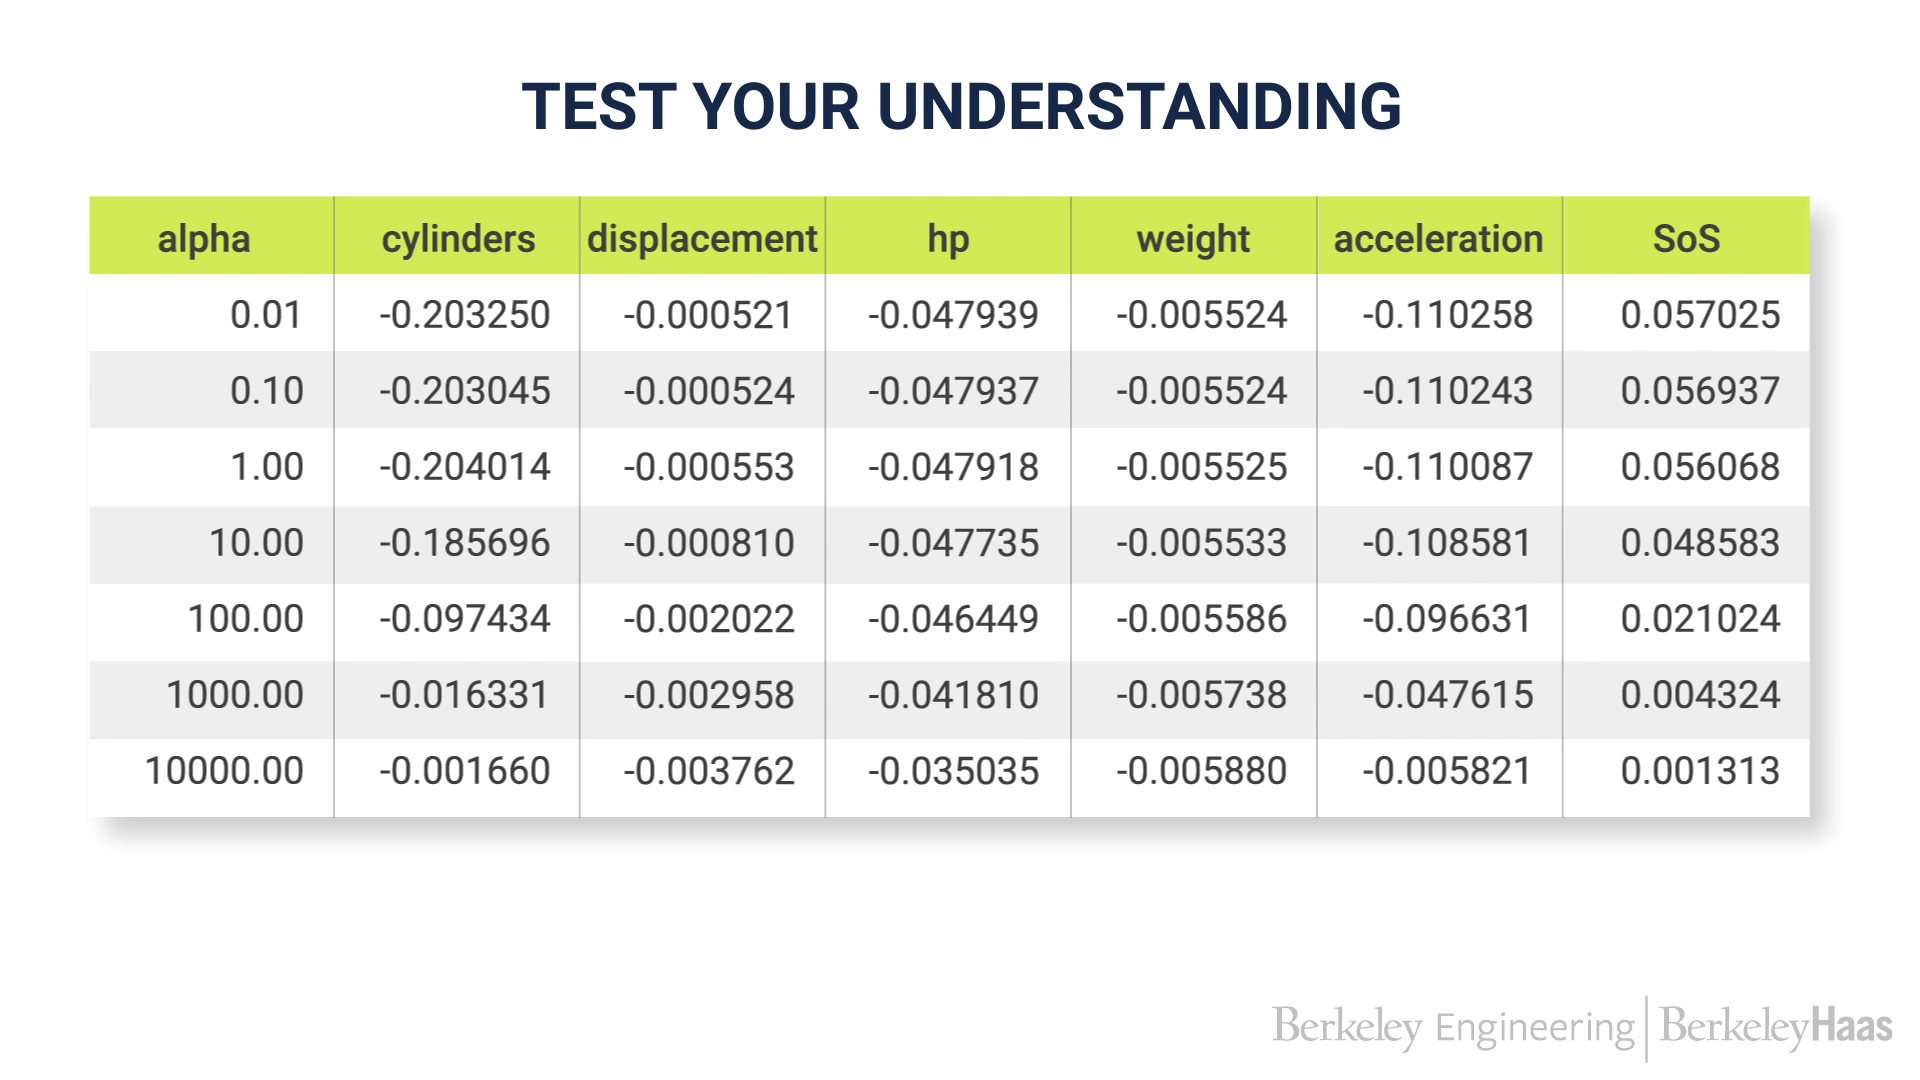

### Summary of Alpha Impact on Coefs
Important contrast with SFS is that ridge model keeps all features, just de-emphasizes them

As alpha...
- ... increases, model loses its ability to use a specific feature whose weight keeps decreasing
- ... decreases, model approaches normal linear regression

## Alpha and Training Error

### vs. Alpha

As alpha increases, training error also increases, since you are attenuating the ability of the model to "express itself"

Note use of log scale for x axis, because need huge alpha to show huge impact

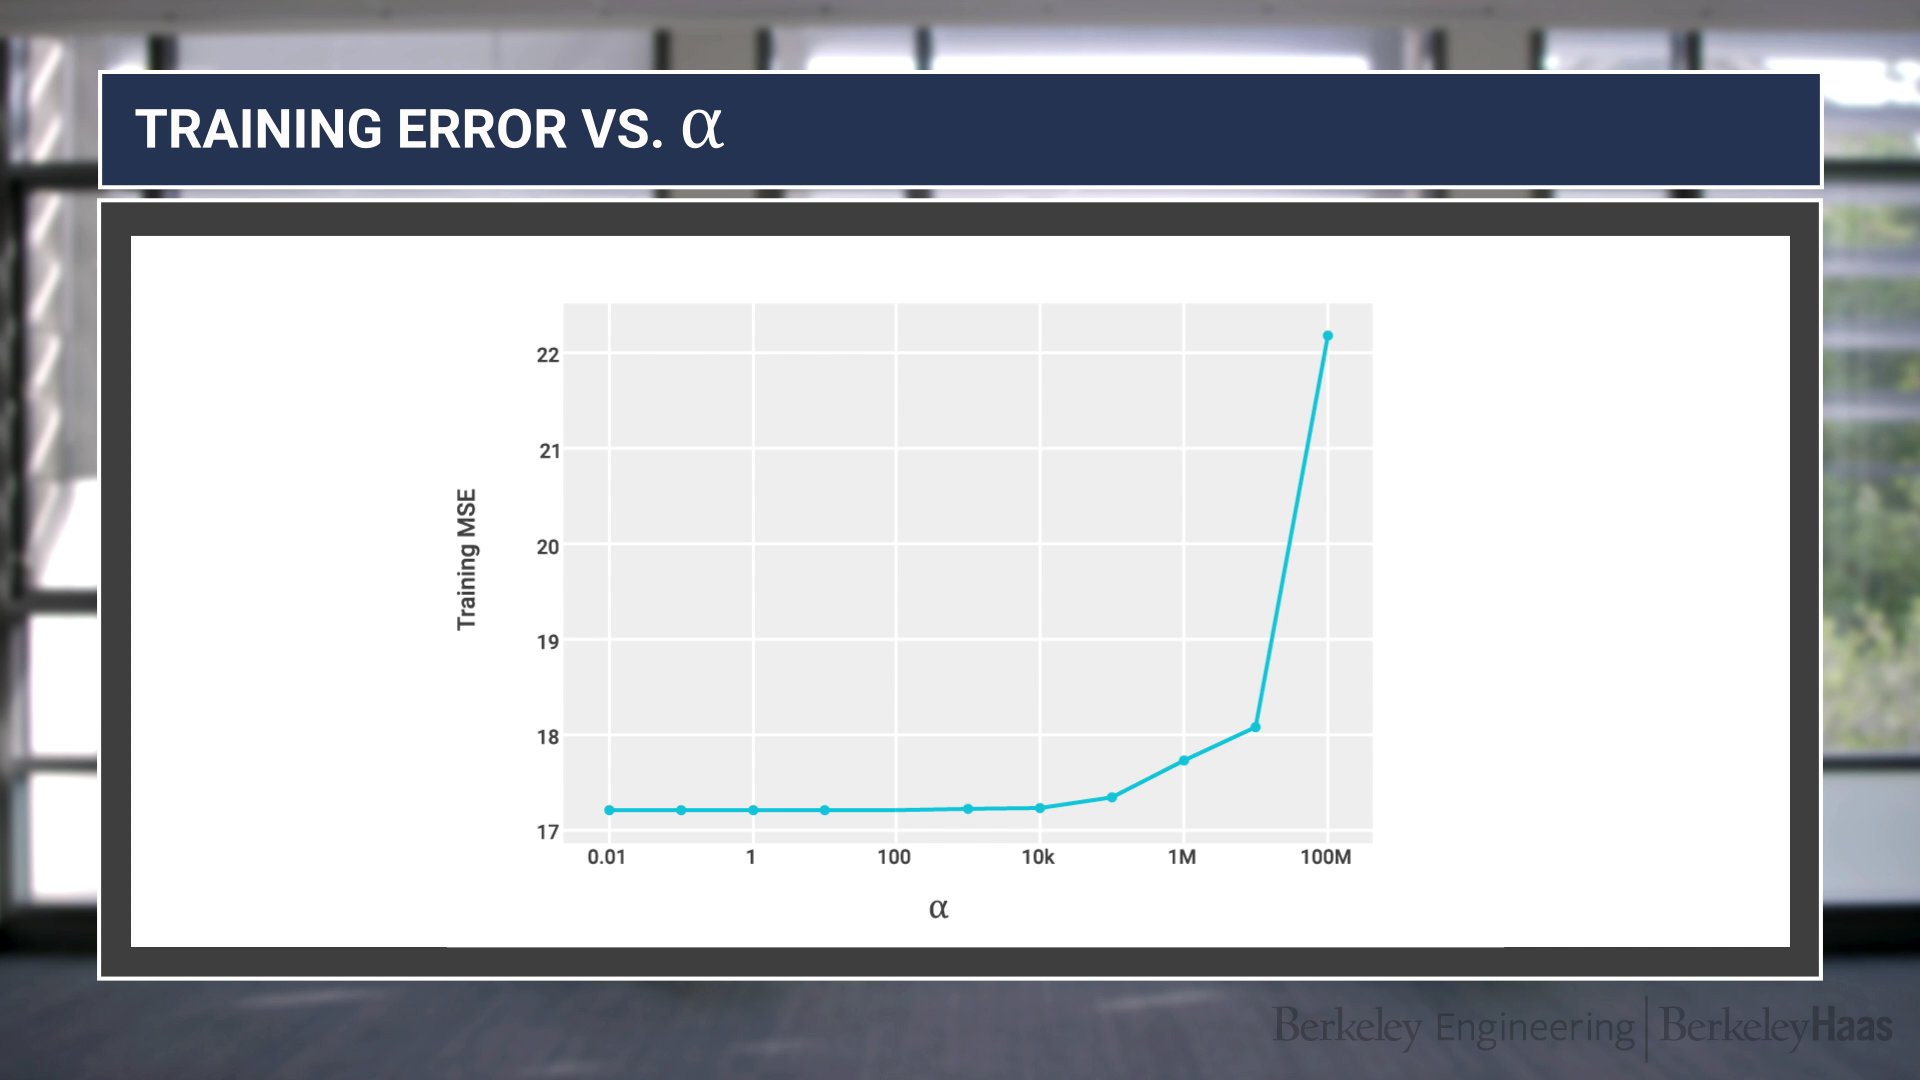

### vs. 1/Alpha

By looking at alpha inverse, looks just like prior plots of error vs. complexity, with error decreasing as we proceed left to right

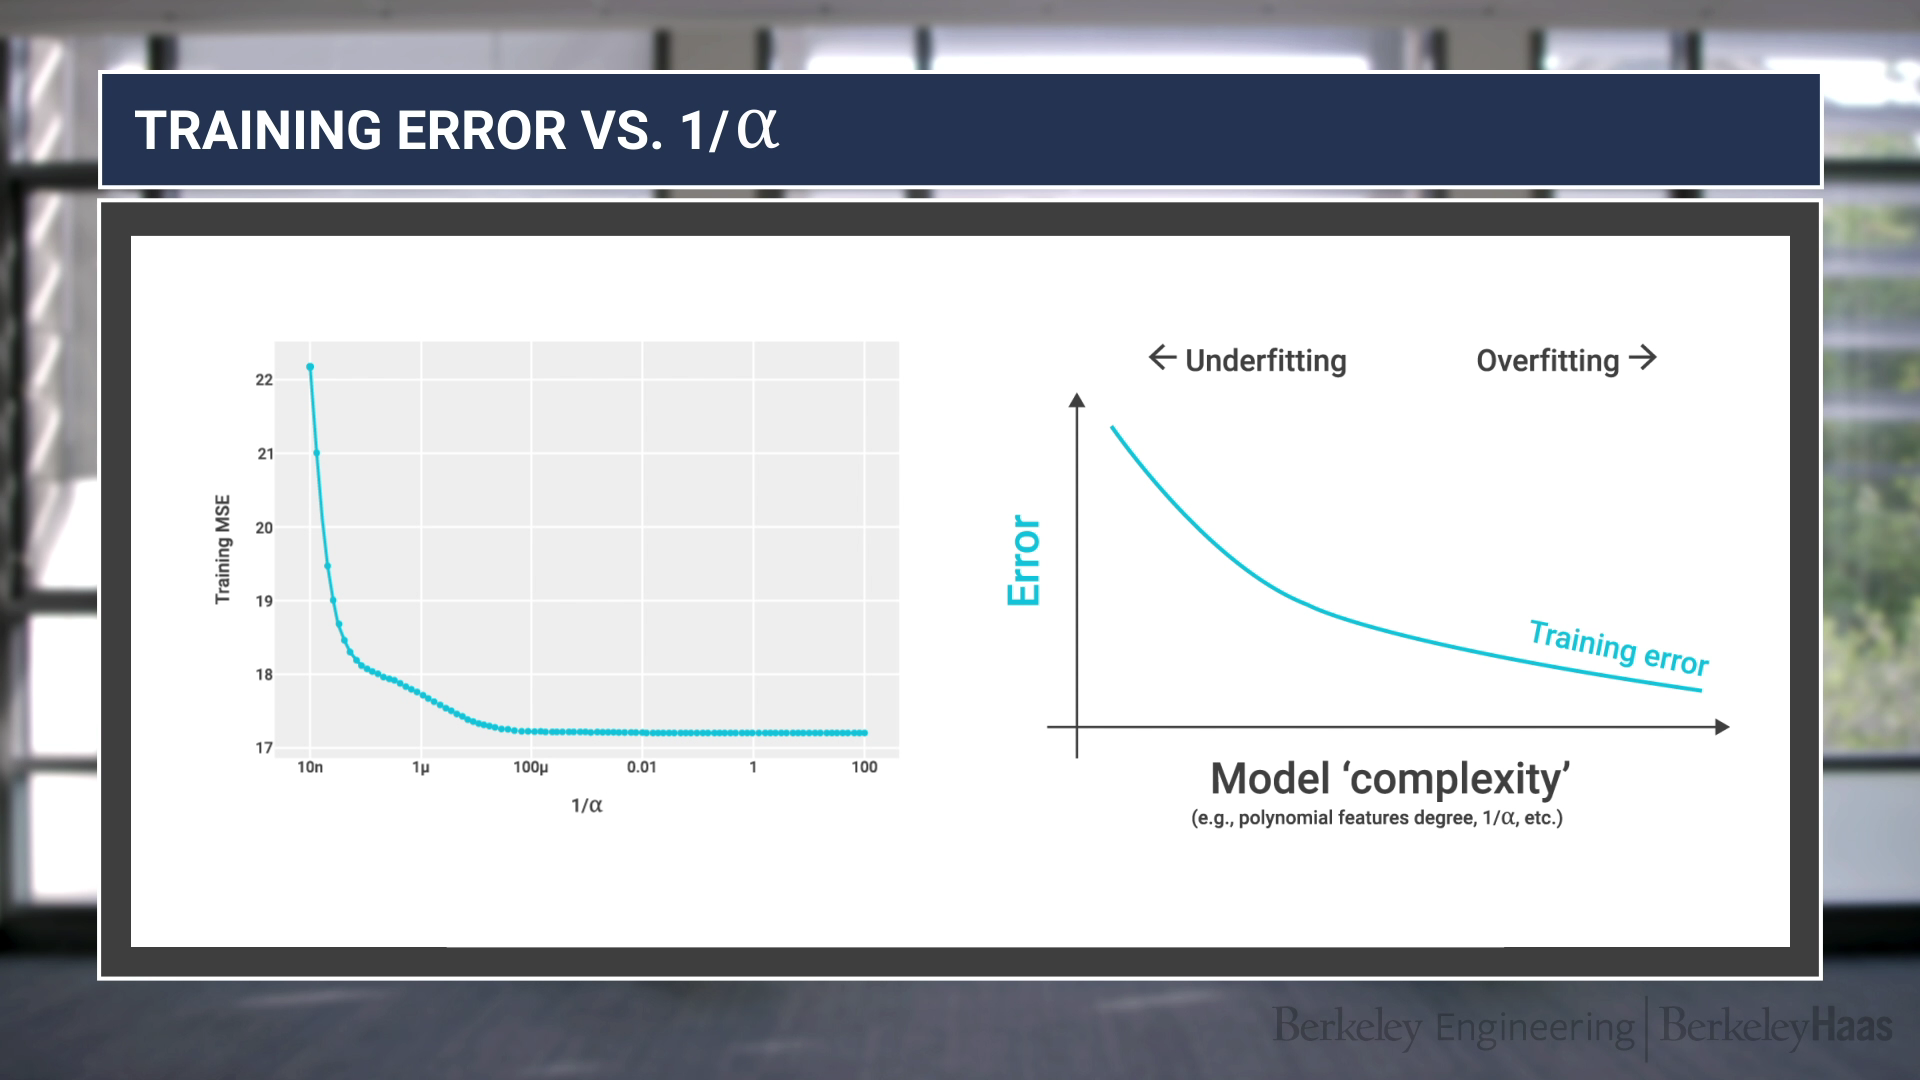

### Interpretations

Notice that you can now operate a continuous range of complexity, in contrast to fixed steps of polynomial degree

Also notice that the MSE drops for a while, and then asymptotes at about alpha = 100 with MSE about 17
- Reason for asymptote is that the model essentially reverts to linear fit, so the floor of the function is error from linear fit